# WAXS Fitting Workflow
This notebook performs loading, q-space mapping, and fitting of WAXS data from EDF files.

---

## 1. Import Libraries

In [1]:
from saxs_utils_GH import *
import matplotlib.pyplot as plt
import numpy as np
import fabio
import os
import pickle
from tabulate import tabulate

from matplotlib.ticker import LogLocator
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import time 

## 2. Define Utility Functions
### (already moved to another file to clean up the notebook, just use from saxs_utils_LB import *)

## 3. File Selection and Load data
Use the file chooser widget to select your EDF files.

In [2]:

# --- new lists ---
filenames = []
sample_names = []
full_paths = []

# Folder inside the repository
folder = os.path.join(os.getcwd(), "data")

for i in [64670]:
    filename = f"WAXS_0_{i}.edf"
    filenames.append(filename)
    full_path = os.path.join(folder, filename)
    full_paths.append(full_path)
    print("file name:", filename)
    sample_names.append(get_sample_name(full_path))

file name: WAXS_0_64670.edf
sample name: EmptyKAptonTubeWAXS


In [3]:
print("total number of files:",len(filenames))

total number of files: 1


## 5. Q-Mapping and Background Subtraction
### Choose a wedge size and q size.

In [4]:
this_q_range_in = np.array([0.0,1])
this_ROI_size = 860
theta_ranges = np.array([-0.6,0.6])# For normal (equitorial) np.array([[-np.pi*0.85,np.pi*0.85]])
invert_theta_mask = False
q_range = get_real_q(full_paths[0],this_ROI_size)
print(os.path.join(folder,filenames[0]))
get_sample_name(full_paths[0])
sample_test = get_2d(full_paths[0],
       this_q_range_in,theta_ranges,invert_theta_mask,ROI_size=this_ROI_size)
this_filepath = full_paths[0]
#q_waxs, = get_1D(this_filepath,this_q_range_in,theta_ranges,invert_theta_mask,ROI_size=860)


Sample to detector distance: 55.0004 mm
Pixel Size: 7.5e-05 m, 75.0 um
Wavelength: 1.54189e-10 m
C:\Users\lubs\Documents\SAXS data (DTU Xeuss 3 machine)\260625LithiatedFibres\WAXS\WAXS_0_64670.edf
sample name: EmptyKAptonTubeWAXS


## optional: Show the mask you have created from above params:

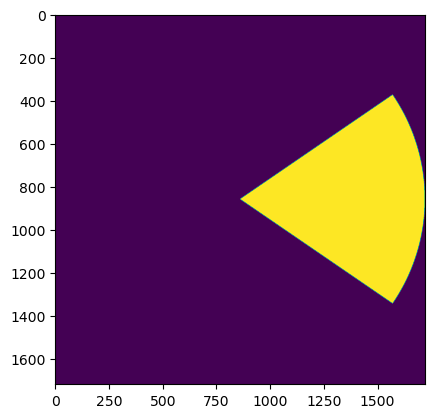

In [5]:
this_mask = calc_theta_mask(sample_test,theta_ranges,invert_theta_mask)*calc_q_mask(sample_test,this_q_range_in)
plt.imshow(this_mask)

In [6]:
# use plot_2d_scan to plot 

sample name: EmptyKAptonTubeWAXS
Sample to detector distance: 55.0004 mm
Pixel Size: 7.5e-05 m, 75.0 um
Wavelength: 1.54189e-10 m


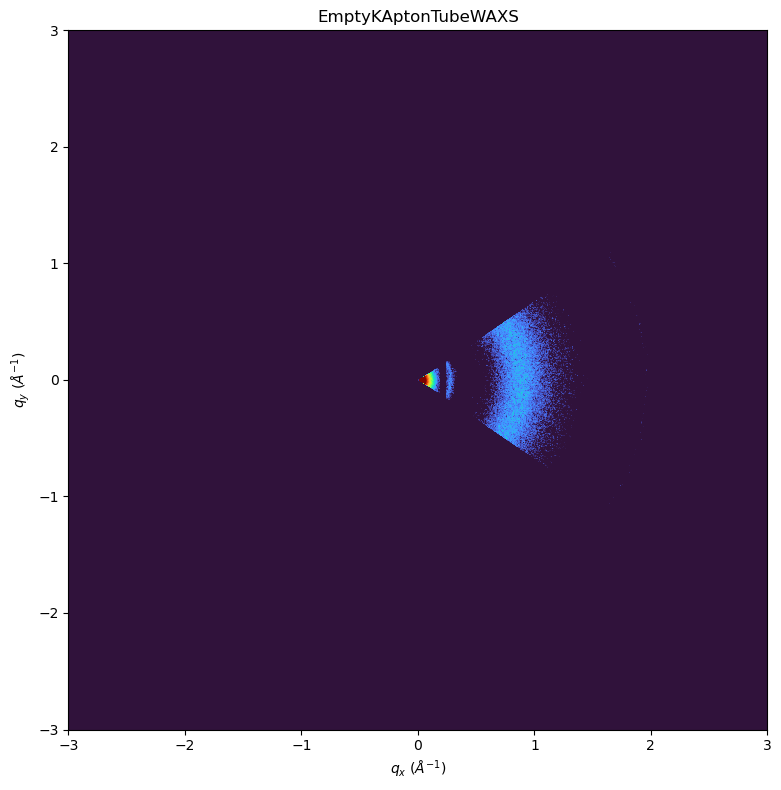

In [7]:
plot_vmax=5
plot_vmin = 2
plot_xlim=(-3,3)
plot_ylim=(-3,3)
plot_2d_scan(full_paths[0],
    this_q_range_in,
    theta_ranges,
    invert_theta_mask,
    this_ROI_size,
    plot_vmax,
    plot_vmin,
    plot_xlim,
    plot_ylim,
    save=False, #whether to save or not.
    savepath=None #if saving, specify output filepath and name.
)

In [8]:
# plt.figure(figsize=[12,8])
# vmaxes = 5
# vmins = 1.5

# this_scan = get_2d(full_paths[0], this_q_range_in, theta_ranges, invert_theta_mask, ROI_size=this_ROI_size)
# plt.figure()
# sample_name = get_sample_name(full_paths[0])
# q_range = get_real_q(full_paths[0],this_ROI_size)
# axis_data_real_units = np.concatenate((-np.flip(q_range,0),q_range))
# plt.imshow(np.log(this_scan+1e-2), vmin=vmins, vmax=vmaxes, cmap='turbo', aspect=1,
#                extent=[axis_data_real_units[0], axis_data_real_units[-1], axis_data_real_units[0], axis_data_real_units[-1]])
# plt.title(sample_name)
# plt.xlabel(r"$q_x$ $(Å^{-1})$")
# plt.ylabel(r"$q_y$ $(Å^{-1})$")
# plt.ylim([-3,3])    
# plt.xlim([-3,3])    
# plt.tight_layout()
# plt.show()



# 1D Integration

In [47]:

t1 = time.time()
print("performing 1D integration...")
q_waxs, data1D = get_1D(full_paths[0], this_q_range_in, theta_ranges, invert_theta_mask, ROI_size=this_ROI_size)
t2 = time.time()
print()
print()
print()
print("loaded, time",(t2-t1),"s")

Sample to detector distance: 55.0004 mm
Pixel Size: 7.5e-05 m, 75.0 um
Wavelength: 1.54189e-10 m



loaded, time 31.774080514907837 s


sample name: EmptyKAptonTubeWAXS


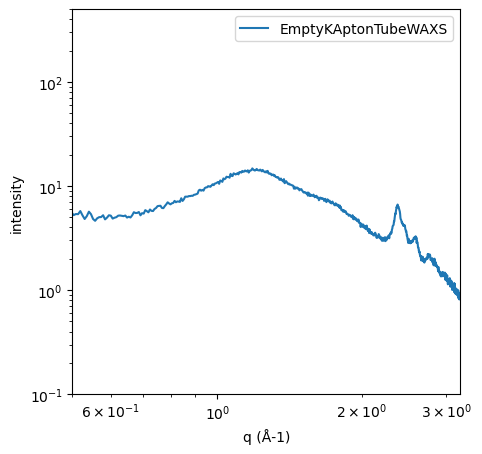

In [52]:
plt.figure(figsize=[5,5])

plt.plot(q_waxs,data1D,label=get_sample_name(full_paths[0]))
plt.yscale("log")
plt.xscale("log")
plt.xlim([0.5,3.2])
plt.ylim([1e-1,5e2])
plt.ylabel("intensity")
plt.xlabel("q (Å-1)")
plt.legend()

# 6. Peak Fitting

## define q range (in pixels) 

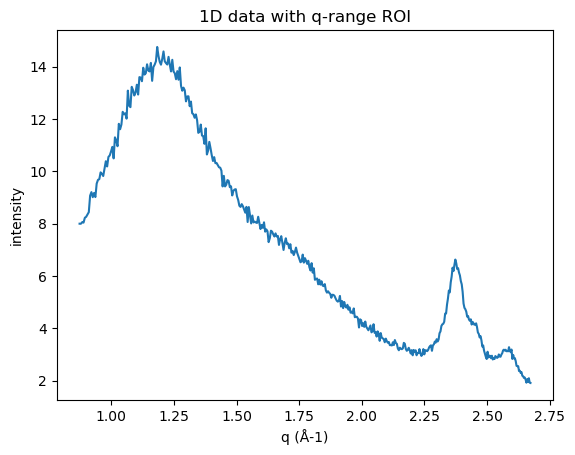

In [57]:
q_roi = (160, 580) 

plt.plot(q_waxs[q_roi[0]:q_roi[1]],data1D[q_roi[0]:q_roi[1]])
plt.ylabel("intensity")
plt.xlabel("q (Å-1)")
plt.title("1D data with q-range ROI")
plt.show()

## define number of peaks to fit 

In [62]:
n_peaks = 6
# Number of parameters per peak:
params_per_peak = 4 #leave as 4.


# specify init guesses and bounds and perform fitting

Kapton only
Peak  	Label                    	Amplitude      	Mean (q)       	Stddev (FWHM)       	C         
----------------------------------------------------------------------------------------------------
Gaussian 1	kapton 1                 	8.506e+00      	1.208e+00      	1.890e-01           	3.593e-01 
Gaussian 2	kapton 2                 	2.587e+00      	1.685e+00      	1.540e-01           	3.593e-01 
Gaussian 3	kapton 3                 	3.485e+00      	2.375e+00      	3.456e-02           	3.593e-01 
Gaussian 4	kapton 4                 	1.191e+00      	2.458e+00      	2.447e-02           	3.593e-01 
Gaussian 5	kapton 5                 	8.188e-01      	2.575e+00      	3.225e-02           	3.593e-01 
Gaussian 6	bg                       	1.711e+00      	9.638e+00      	1.104e-01           	3.593e-01 
Lin BG -2.379e+00      6.352e+00      


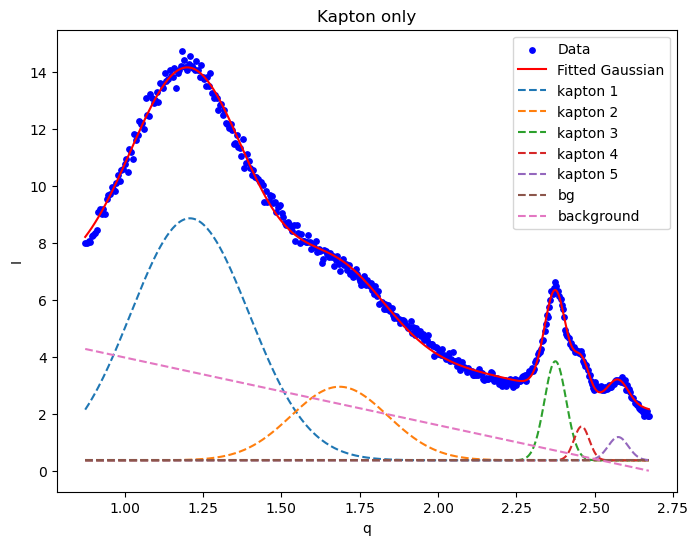

In [63]:
peak_labels = [f'kapton {i}' for i in range(1, n_peaks)] + ['bg']


## Define initial guesses of each peak.
#For each peak, These 4 parameters must be specified in initial guess :
# amplitude, mean, stddev, constant offset

#these are stored in "initial guess":

initial_guess = [
    8.5e+00, 1.2e+00,6.088e-02, 2.923e-01,  # kapton 1
    2.8e+00, 1.86e+00, 4.400e-02, 2.923e-01,  # kapton 2
    1.527e+00, 2.440e+00, 2.454e-02, 2.923e-01,  # kapton 3
    1.232e+00, 2.535e+00, 1.852e-02, 2.923e-01,  # kapton 4
    1.000e+00, 2.620e+00, 3.169e-02, 2.923e-01,  # kapton 5
    1.000e+00, 2.800e+00, 3.169e-02, 2.923e-01,  # kapton 6
#the last two values are your two values for initial guess in the Linear background, m and c in y=mx+c
    -0.4, 0.5  # linear background
]

#define lower and upper bounds for background.
BG_LB = (-100, -100)
BG_UB = (100, 100)


# Compute bounds for peaks.
#these are just defined as multiples of ecah value. You can also enter your own.
lb = []
ub = []

for i in range(n_peaks):
    start = i * params_per_peak
    end = start + params_per_peak
    peak_params = initial_guess[start:end]
    lb += [0.5 * x for x in peak_params]
    ub += [3.5  * x for x in peak_params]  

# Append background bounds
lb += list(BG_LB)
ub += list(BG_UB)

this_bounds = (lb, ub)

# Metadata
fig_title = "Kapton only"
fig_name = "Kapton only"

# Call the fitting function
fit_waxs_arbitrary_n_peaks_linbg(
    initial_guess,
    this_bounds, 
    q_waxs, #q values
    data1D, #data
    q_roi, #ROI 
    n_peaks, 
    peak_labels,
    fig_title,
    fig_name,
    savefig=False, #set to true if you want to save. 
    filepath=None #set to none means output will save to current working dir. Otherwise specify output filepath here. 
    
)


In [59]:
#get the above params and store in a variable, if needed.
kapton_peak_vals = fit_waxs_arbitrary_n_peaks_linbg_return_vals(initial_guess,
    this_bounds,
    q_waxs,
    data1D,
    q_roi,
    n_peaks,
    peak_labels,
    fig_title,
    fig_name,
    False
)


Kapton only
Peak      Amplitude      Mean (q)       Stddev (FWHM)       C         
----------------------------------------------------------------------
Gaussian 1  | 8.506e+00       | 1.208e+00       | 1.890e-01            | 3.593e-01 
Gaussian 2  | 2.587e+00       | 1.685e+00       | 1.540e-01            | 3.593e-01 
Gaussian 3  | 3.485e+00       | 2.375e+00       | 3.456e-02            | 3.593e-01 
Gaussian 4  | 1.191e+00       | 2.458e+00       | 2.447e-02            | 3.593e-01 
Gaussian 5  | 8.188e-01       | 2.575e+00       | 3.225e-02            | 3.593e-01 
Gaussian 6  | 1.711e+00       | 9.638e+00       | 1.104e-01            | 3.593e-01 
